# Network Analysis

In this notebook we are conducting exploratory analysis on the graphs created from the data in `data/games/network_raw` and `data/games/network`. We are also using the metadata available in `data/games/metadata/all_games.csv`. We look at betweenness connectivity, connected components, node degree, etc.

In [2]:
import csv

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from networkx.algorithms import pagerank
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

In [3]:
FINAL_DATE = datetime(2023, 1, 1)

### Helper Functions

In [3]:
def generate_network_filter(filename: str, disallowed_games=None, allowed_games=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        filter_map = defaultdict(bool)
        for row in csv_reader:
            # Check if the created/release date is after 2023, if it is then we can ignore it in the network.
            release_date = datetime.strptime(row[3], "%Y-%m-%d")
            if row[4] == "None":
                row[4] = "2017-10-22T05:21:29Z" # This is a completely random date before the final date.
            created_date = datetime.strptime(row[4], "%Y-%m-%dT%H:%M:%SZ")

            if disallowed_games == None:
                disallowed_games = ["y65797de"]

            if allowed_games == None:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games:
                    filter_map[row[0]] = True
            else:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games and row[0] in allowed_games:
                    filter_map[row[0]] = True

    return filter_map

def get_weighted_edges_from_csv(filename, filter=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)

        edges = list()
        for row in csv_reader:
            if filter is None:
                edges.append(tuple([row[0], row[1], int(row[2])]))
                continue
            
            if not filter.get(row[0]) or not filter.get(row[1]):
                continue

            edges.append(tuple([row[0], row[1], int(row[2])]))

    return edges

def generate_graph_from_edges(edges_list):
    directed_graph = nx.DiGraph()
    directed_graph.add_weighted_edges_from(edges_list)
    return directed_graph

def save_weighted_graph(g: nx.DiGraph, filename: str):
    with open(filename, 'w', encoding='utf-8') as openfile:
        openfile.write("Source,Target,Weight\n")
        for source,target,data in g.edges(data=True):
            weight = int(data['weight'])
            output_string = ','.join(map(str, [source, target, weight]))
            openfile.write(f"{output_string}\n")

In [14]:
def format_games_metadata_dataframe(df: pd.DataFrame):
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)
    
    # Remove rows with N/As in them.
    df = df.dropna()
    
    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
    
    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') & (df['release_date'] < '2023-01-01')] 
    
    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
    
    # Rename the game_id column to just id.
    df.rename(columns = {'game_id' : 'id'}, inplace=True)

    return df

### Metric Functions

In [5]:
def find_top_n_pagerank_nodes(g: nx.Graph, n=1):
    values = pagerank(g)
    values_sorted = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
    return list(values_sorted)[0:n]

def get_graph_order_size(g: nx.Graph):
    return g.order(), g.size()

def find_top_n_betweenness_centrality_nodes(g: nx.Graph, n=10):
    degree_centrality = nx.degree_centrality(g)
    betweenness_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)

    degree_centrality_sorted = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
    betweenness_centrality_sorted = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))

    keys_top_degree = list(degree_centrality_sorted)[0:n]
    keys_top_betweenness = list(betweenness_centrality_sorted)[0:n]
    return list(set(keys_top_degree) & set(keys_top_betweenness))

def find_degree_sequence(g: nx.Graph):
    return [g.degree(n) for n in g.nodes]

def find_top_n_highest_out_degree_node(g: nx.Graph, n=10):
    return sorted(g.out_degree(), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_out_degree_with_weight(g: nx.Graph, n=10):
    return sorted(g.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_in_degree_node(g: nx.Graph, n=10):
    return sorted(g.in_degree(), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_in_degree_with_weight(g: nx.Graph, n=10):
    return sorted(g.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:n]


# Exploratory Analysis

We are generating a network using the entire related games network that has been filtered using the previously mentioned function. This gives us a directed graph with **30,433 nodes**, and **14,739,311 edges**. Without filtering, we get a network that has **30,970 nodes** and **14,857,762 edges**. The filtering removes **537 nodes** and **118,451 edges**.

In [6]:
filter_filename = "../data/games/metadata/all_games.csv"
graph_filename = "../data/too_big/all_games.csv"
filter_map = generate_network_filter(filter_filename)
edges = get_weighted_edges_from_csv(graph_filename, filter=filter_map)
filtered_graph = generate_graph_from_edges(edges)
print(f"FILTERED: {get_graph_order_size(filtered_graph)}")

FILTERED: (30433, 14739311)


In [8]:

edges = get_weighted_edges_from_csv(graph_filename, filter=None)
unfiltered_graph = generate_graph_from_edges(edges)
print(f"UNFILTERED: {get_graph_order_size(unfiltered_graph)}")
del unfiltered_graph

UNFILTERED: (30970, 14857762)


## Connected Components of the Games Network

In [9]:
print(f"HIGHEST OUT: {find_top_n_highest_out_degree_node(filtered_graph)}")
print(f"HIGHEST OUT WITH WEIGHT: {find_top_n_highest_out_degree_with_weight(filtered_graph)}")
print(f"HIGHEST IN: {find_top_n_highest_in_degree_node(filtered_graph)}")
print(f"HIGHEST IN WITH WEIGHT: {find_top_n_highest_in_degree_with_weight(filtered_graph)}")

HIGHEST OUT: [('k6q4rqzd', 9206), ('o1y9j9v6', 7491), ('o1y9wo6q', 7294), ('k6q474zd', 6850), ('om1m3625', 6794), ('46w0n91r', 6683), ('9d3rv59d', 6648), ('3dxz7p1y', 6294), ('pd0wq31e', 6288), ('76rmo418', 6001)]
HIGHEST OUT WITH WEIGHT: [('k6q4rqzd', 151023), ('o1y9wo6q', 101462), ('k6q474zd', 89935), ('o1y9pyk6', 80571), ('o1yj5n21', 79892), ('j1n29w1p', 75175), ('369pxvg1', 72947), ('m1mnnojd', 69459), ('76r55vd8', 69281), ('kdknmqdm', 67686)]
HIGHEST IN: [('k6q4rqzd', 9211), ('o1y9j9v6', 7488), ('o1y9wo6q', 7302), ('k6q474zd', 6855), ('om1m3625', 6795), ('46w0n91r', 6696), ('9d3rv59d', 6656), ('3dxz7p1y', 6299), ('pd0wq31e', 6293), ('76rmo418', 6004)]
HIGHEST IN WITH WEIGHT: [('k6q4rqzd', 2005087), ('j1ne0vl1', 1643535), ('nd285r3d', 1093294), ('w6jl9o5d', 967633), ('3dx2j9y1', 840104), ('j1ll47v1', 758797), ('o1y7pv1q', 553313), ('m1zjnrm6', 551302), ('o1yj5n21', 521378), ('9dowpxm1', 487811)]


The graph is composed of **38 weakly connect components** and **47 strongly connected components**. This means that instead of one large graph creating our network, we have several components that create the overall graph. Inspecting these components, we find one massive component and multiple incredibly small components. This means that **we have a main graph that is extremely well connected**, and **several disconnected sub-graphs**. This means that **the average player plays popular games that many other players have played**. We can inspect these small components and find that they are rare cycles where there are only a few players of a game, and those players have *only* played those games.  

In [10]:
print(f"IS WEAKLY CONNECTED: {nx.is_weakly_connected(filtered_graph)}")
print(f"IS STRONGLY CONNECTED: {nx.is_strongly_connected(filtered_graph)}")

IS WEAKLY CONNECTED: False
IS STRONGLY CONNECTED: False


In [8]:
print(f"NO. OF WEAKLY CONNECTED COMPONENTS: {nx.number_weakly_connected_components(filtered_graph)}")
print(f"NO. OF STRONGLY CONNECTED COMPONENTS: {nx.number_strongly_connected_components(filtered_graph)}")

NO. OF WEAKLY CONNECTED COMPONENTS: 38
NO. OF STRONGLY CONNECTED COMPONENTS: 47


In [9]:
weak_components = sorted([component for component in nx.weakly_connected_components(filtered_graph)], key=len, reverse=True)
strong_components = sorted([component for component in nx.strongly_connected_components(filtered_graph)], key=len, reverse=True)

largest_weak_component = max(weak_components, key=len)
largest_strong_component = max(strong_components, key=len)

print(f"Largest weak component: {len(largest_weak_component)}\nLargest strong component: {len(largest_strong_component)}")

Largest weak component: 30344
Largest strong component: 30335


In [15]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[[
    'num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [16]:
games_list = weak_components[2]
games_metadata_df[(games_metadata_df['id'].isin(games_list))]

NameError: name 'weak_components' is not defined

In [ ]:
del weak_components
del strong_components

## Betweenness Centrality of the Games Network 

Below we are doing an inner join on the games metadata dataframe and the calculated betweenness centrality of the full games network. This gives us all the metadata about the games including their betweenness centrality values.

In [17]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

betweenness_centrality_filename = "../data/games/network/all_games_betweenness_centrality.csv"
betweenness_centrality_df = pd.read_csv(betweenness_centrality_filename)

merged_df = betweenness_centrality_df.merge(games_metadata_df, on='id', how='inner')

In [18]:
merged_df.describe(include='all', datetime_is_numeric=True)

,id,value,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
count,30440,3.044000e+04,30440,30440,30440,30440,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000
unique,30433,NaN,30414,7886,8317,29654,NaN,NaN,NaN,NaN,NaN
top,v1pxwk86,NaN,Dreams,None,2015-01-01,None,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,3,17222,357,779,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.611297e-05,NaN,NaN,NaN,NaN,4.055125,7.372208,103.919284,22.278581,2.077135
std,NaN,2.735144e-04,NaN,NaN,NaN,NaN,4.461197,32.478199,677.609514,135.789522,92.810672
min,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,0.000000,-999.000000,0.000000,0.000000
25%,NaN,5.762778e-08,NaN,NaN,NaN,NaN,2.000000,0.000000,4.000000,2.000000,0.000000
50%,NaN,3.268143e-06,NaN,NaN,NaN,NaN,3.000000,0.000000,12.000000,4.000000,0.000000
75%,NaN,3.254986e-05,NaN,NaN,NaN,NaN,5.000000,5.000000,44.000000,11.000000,0.000000


We now have the top games sorted by their betweenness centrality.

In [19]:
top_n_values = 5
merged_df.sort_values(by='value', ascending=True).tail(top_n_values).iloc[::-1]


,id,value,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
698,o1y9j9v6,0.013859,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14
666,o1y9wo6q,0.012831,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
568,nd22xvd0,0.010138,Refunct,ge0ry3ep,2015-10-16,2015-10-20T00:23:48Z,4,0,5669,1568,6
657,4pd0n31e,0.009962,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65
3887,9d3rr0dl,0.009366,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46


We can do the same, but grouped by the developer -- this gives us the developers with the games that have the highest betweenness centrality. **The higher the sum of the value, the more common it is for games by this developer to be an entry game into speedrunning.**

In [20]:
grouped_bc_df = merged_df.groupby(['developers'])
grouped_bc_sum_df = grouped_bc_df.sum(numeric_only=True)
grouped_bc_sum_df['num_games_per_developer'] = grouped_bc_df.count().iloc[:, 0]
grouped_bc_sum_df.sort_values(by="value", ascending=True).tail(top_n_values).iloc[::-1]

,value,num_categories,num_levels,num_runs,num_users,num_guests,num_games_per_developer
developers,,,,,,,
None,0.726940,60285,95594,972290,225436,12505,17222
xv6dvx62,0.091023,724,2208,171597,33631,1878,107
myzo3pzq,0.036892,947,4552,63151,14860,2152,177
1zk4q26j,0.014529,32,18,33659,5703,18,2
2jevn26k,0.012255,621,485,11449,2716,172,154


In [9]:
import requests
developer = "1zk4q26j"
response = requests.get(f"https://speedrun.com/api/v1/developers/{developer}")
print(response.json().get("data"))

{'id': '1zk4q26j', 'name': 'Matt Makes Games Inc.', 'links': [{'rel': 'self', 'uri': 'https://www.speedrun.com/api/v1/developers/1zk4q26j'}, {'rel': 'games', 'uri': 'https://www.speedrun.com/api/v1/games?developer=1zk4q26j'}]}


By grouping our dataframe by developer and summing the value column, we get the developers that have the highest betweenness centrality of their games. We find that the top developer is `None`. This means that no developer was listed in the speedrun.com API. The next valid value is `xv6dvx62`, which is Nintendo. Therefore, **Nintendo creates games that are most likely to get people into speedrunning**. In order, the next developers are Capcom, Matt Makes Games Inc., Seterra, Marianne Wartoft, Konami, Vicarious Visions, Dominique Grieshofer, SEGA, StudioMDHR Entertainment Inc., Mojang, Toby Fox, Namco, A crossover between Nintendo, Bandai Namco, Sora Ltd., then CLTincknell, Activision, snk, Mateusz Skutnik, KaMiZoTo, and Treyarch.

* [Nintendo](https://nintendo.fandom.com/wiki/List_of_Nintendo_games). Everyone knows Nintendo as it has literally *raised* most adults.
* [Capcom](https://en.wikipedia.org/wiki/List_of_Capcom_games) is previously a titan of arcade games, and owner of franchises such as Street Fighter, Marvel vs. Capcom, Mega Man, Resident Evil, Devil May Cry, Dead Rising, Monster Hunter, Sengoku Basara, Onimusha and Ace Attorney. 
* [Matt Makes Games Inc.](https://www.mattmakesgames.com/) creates games such as Earthblade, Celeste, Towerfall.
* [Marianne Wartoft](https://wartoft.se/) is the creator of Seterra, and created the studio Seterra to continue the development of that website.
* [Konami](https://en.wikipedia.org/wiki/List_of_Konami_games#:~:text=PlayStation%20handhelds%20%20%20%20Title%20%20,July%2018%2C%202019%20%2025%20more%20rows%20) is similar to Capcom. Konami's video game franchises include Metal Gear, Silent Hill, Castlevania, Contra, Frogger, Tokimeki Memorial, Parodius, Gradius, Yu-Gi-Oh!, Suikoden, and eFootball.
* [Vicarious Visions](https://en.wikipedia.org/wiki/Vicarious_Visions) is a game studio that has created a lot of movie tie-in games.
* [Dominique Grieshofer](https://store.steampowered.com/dev/DomGries) has created games such as Refunct and Swarmlake.
* [StudioMDHR Entertainment Inc.](http://studiomdhr.com/about-us/) created Cuphead and the sequel Cuphead: The Delicious Last Course.
* [Mojang](https://www.minecraft.net/en-us/article/meet-mojang-studios) created Minecraft and it's derivatives.
* [Toby Fox](https://en.wikipedia.org/wiki/Toby_Fox) developed Undertale and Deltarune. 
* [Namco](https://en.wikipedia.org/wiki/List_of_Namco_games) is a published credited with creating Pac-Man, and later merged with Bandai.
* [Bandi Namco](https://en.wikipedia.org/wiki/List_of_Bandai_Namco_video_games) is the successor of Namco. They have TONNES of games.

You get the idea...

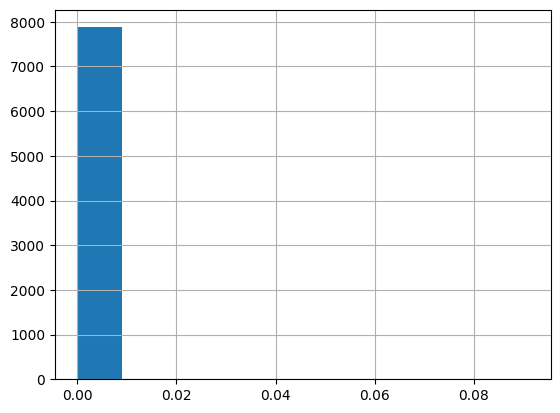

In [21]:
grouped_bc_df_without_none = grouped_bc_sum_df[(grouped_bc_sum_df.index != "None")].sort_values(by="value").iloc[::-1]
grouped_bc_df_without_none['value'].hist()
plt.show()

We look for any correlations between the betweenness centrality and the meta data values, but most of them are uncorrelated apart from **value vs. num_runs** and **value vs. num_users**. This makes sense as these are *the* two drivers of popularity that we are measuring in our network. More users means more runs, and more runs means more popular. 

<Axes: >

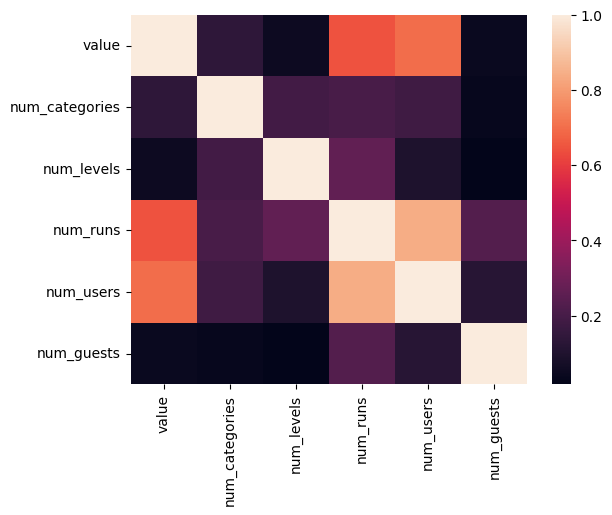

In [11]:
sns.heatmap(merged_df.corr(numeric_only=True))


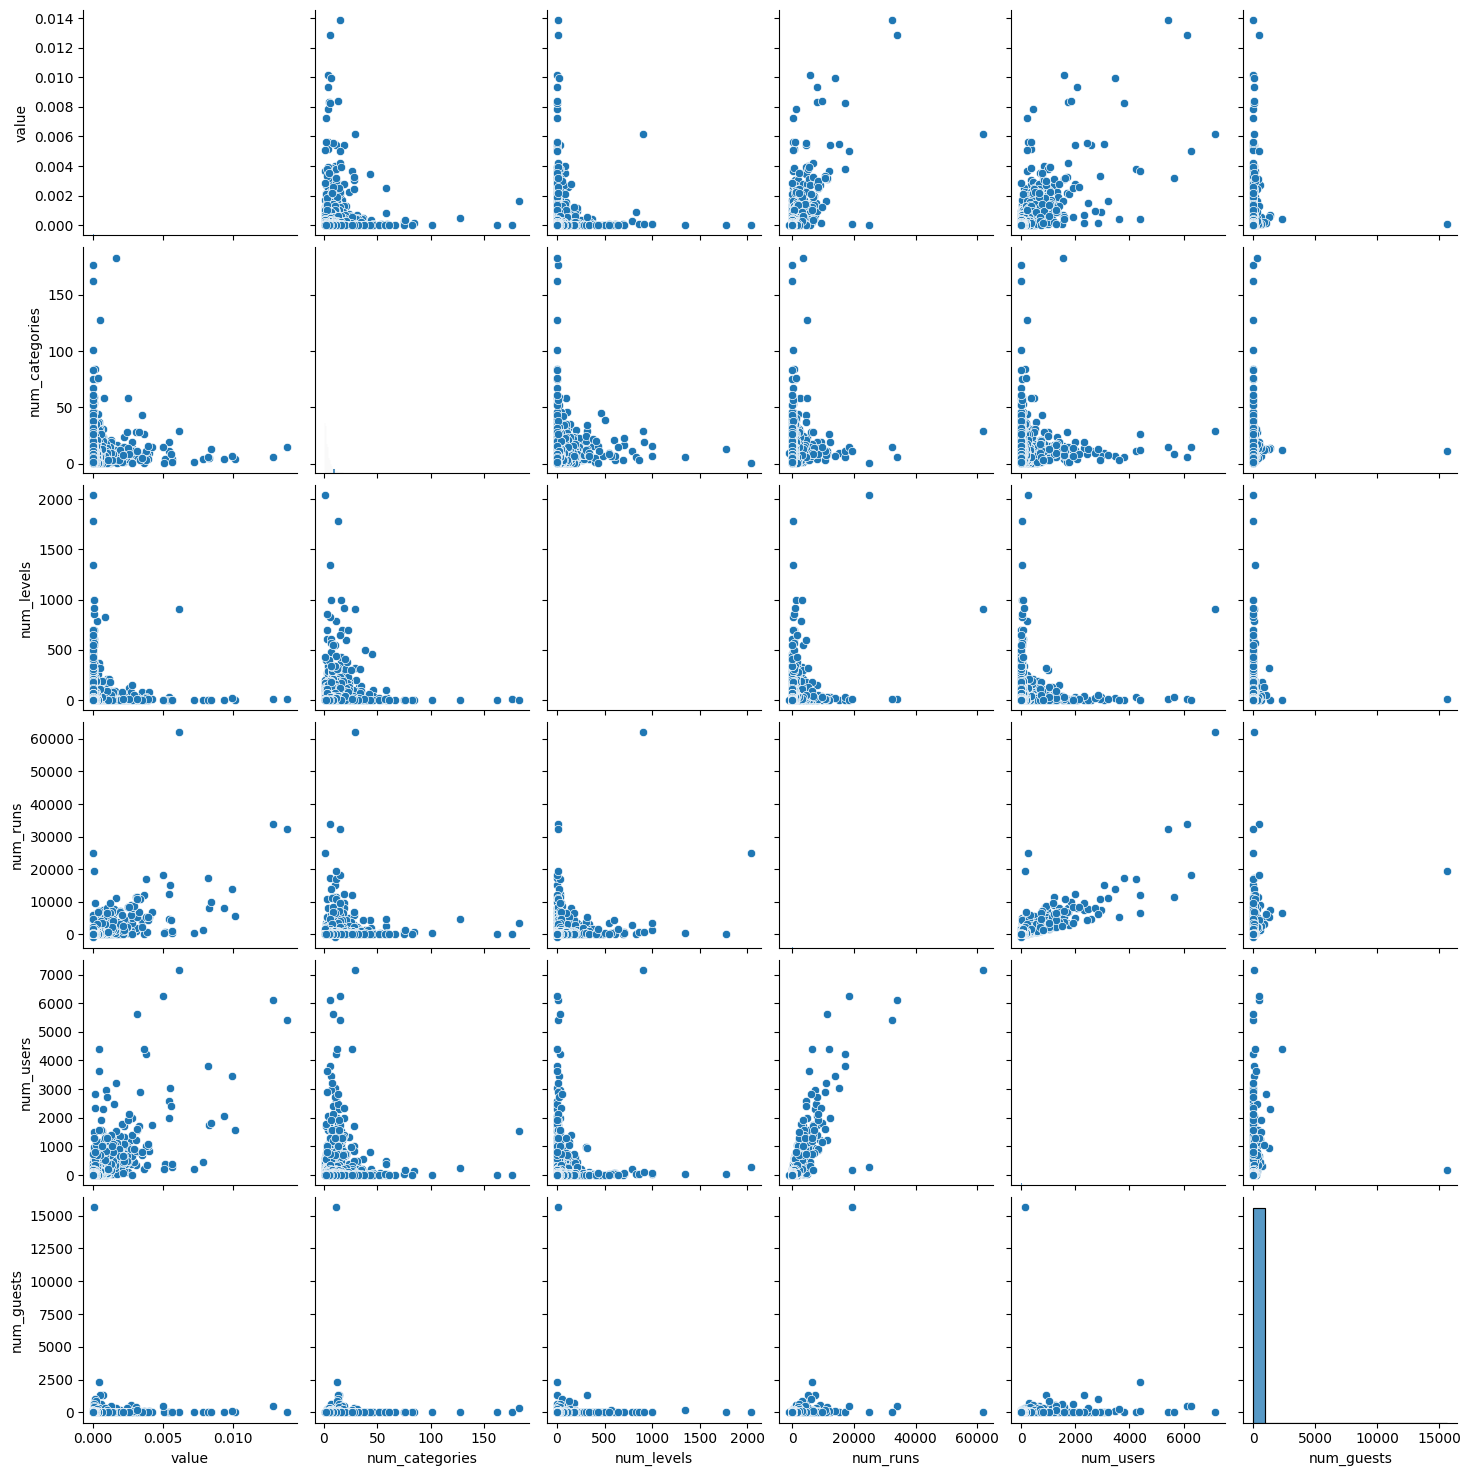

In [12]:
sns.pairplot(merged_df)

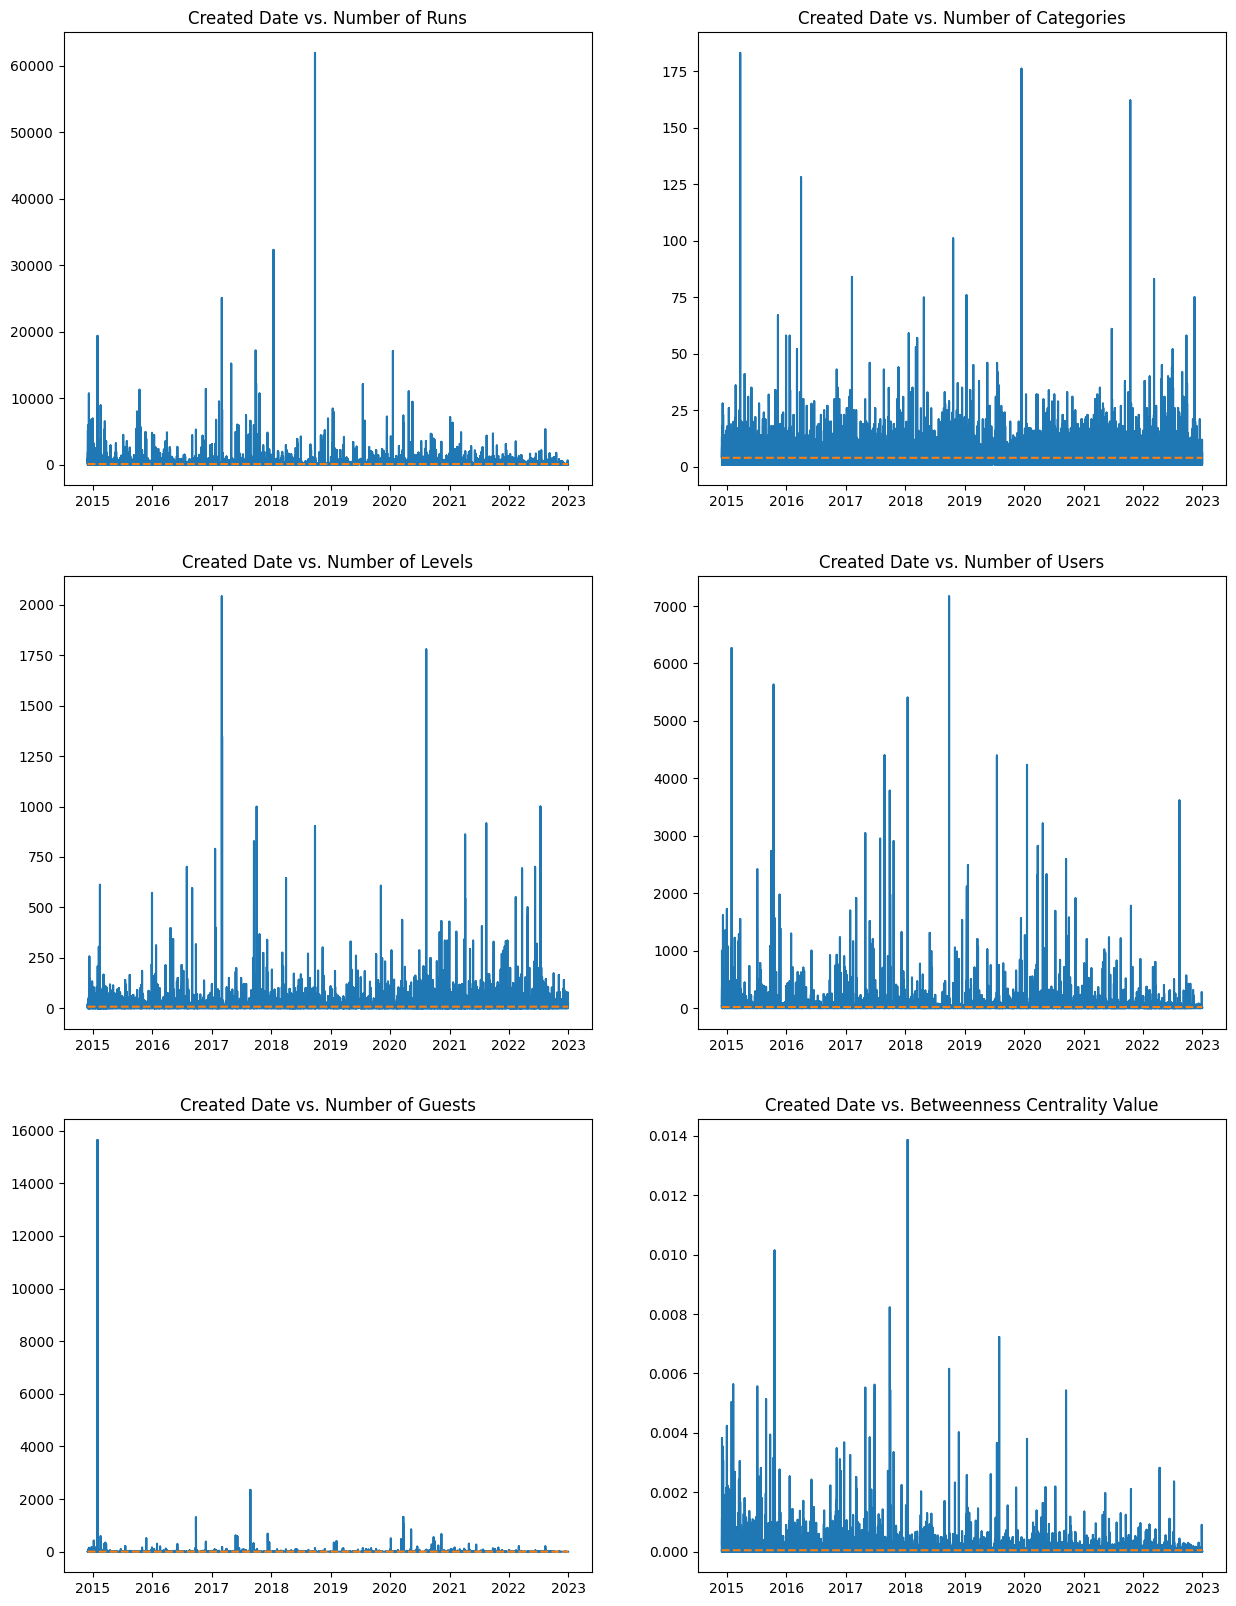

In [25]:
figure, axis = plt.subplots(3, 2)


df = format_games_metadata_dataframe(merged_df).sort_values(by='created_date')
axis[0, 0].plot(df['created_date'], df['num_runs'])
mean = [np.mean(df['num_runs'])]*len(df['created_date'])
axis[0, 0].plot(df['created_date'], mean, linestyle='--')
axis[0, 0].set_title("Created Date vs. Number of Runs")

axis[0, 1].plot(df['created_date'], df['num_categories'])
mean = [np.mean(df['num_categories'])]*len(df['created_date'])
axis[0, 1].plot(df['created_date'], mean, linestyle='--')
axis[0, 1].set_title("Created Date vs. Number of Categories")

axis[1, 0].plot(df['created_date'], df['num_levels'])
mean = [np.mean(df['num_levels'])]*len(df['created_date'])
axis[1, 0].plot(df['created_date'], mean, linestyle='--')
axis[1, 0].set_title("Created Date vs. Number of Levels")

axis[1, 1].plot(df['created_date'], df['num_users'])
mean = [np.mean(df['num_users'])]*len(df['created_date'])
axis[1, 1].plot(df['created_date'], mean, linestyle='--')
axis[1, 1].set_title("Created Date vs. Number of Users")

axis[2, 0].plot(df['created_date'], df['num_guests'])
mean = [np.mean(df['num_guests'])]*len(df['created_date'])
axis[2, 0].plot(df['created_date'], mean, linestyle='--')
axis[2, 0].set_title("Created Date vs. Number of Guests")

axis[2, 1].plot(df['created_date'], df['value'])
mean = [np.mean(df['value'])]*len(df['created_date'])
axis[2, 1].plot(df['created_date'], mean, linestyle='--')
axis[2, 1].set_title("Created Date vs. Betweenness Centrality Value")

df = df.sort_index()

figure.set_figwidth(15)
figure.set_figheight(20)

plt.show()

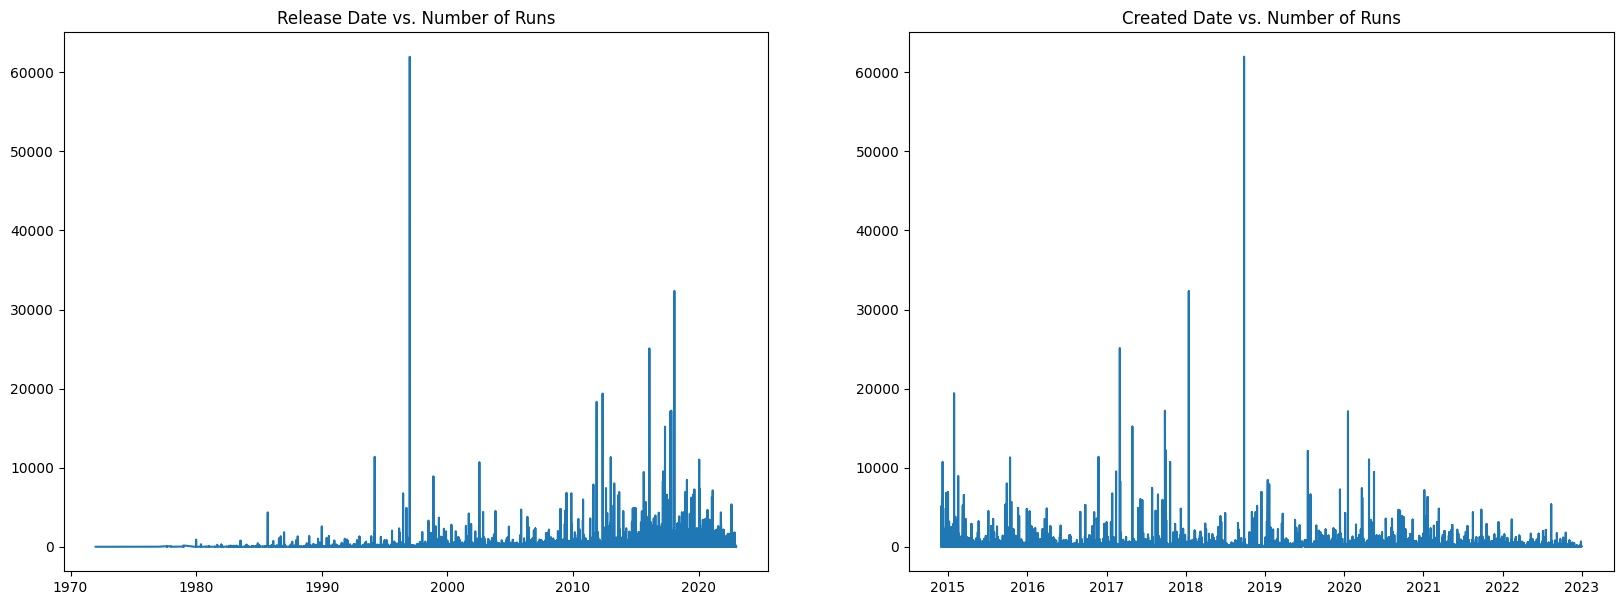

In [26]:
figure, axis = plt.subplots(1, 2)

df = df.sort_values(by='release_date')
axis[0].plot(df['release_date'], df['num_runs'])
axis[0].set_title("Release Date vs. Number of Runs")

df = df.sort_values(by='created_date')
axis[1].plot(df['created_date'], df['num_runs'])
axis[1].set_title("Created Date vs. Number of Runs")

df = df.sort_index()

figure.set_figwidth(20)
figure.set_figheight(7)

plt.show()

## Discrepancy between Files and Graphs

In [35]:
def find_difference_between_metadata_and_network(metadata_filename, graph_filename):
    metadata_games, network_games = set(), set()

    with open(graph_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [network_games.add(row[0]) for row in csv_reader]

    with open(metadata_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [metadata_games.add(row[0]) for row in csv_reader]

    return list(network_games - metadata_games)

def find_number_of_games(filename):
        games = set()
        with open(filename, 'r') as openfile:
                csv_reader = csv.reader(openfile)
                next(csv_reader)
                [games.add(row[0]) for row in csv_reader]
                [games.add(row[1]) for row in csv_reader]
        return len(games)

def find_missing_games_from_network(metadata_filename, graph_filename):
    edges = get_weighted_edges_from_csv(graph_filename, filter=None)
    graph = generate_graph_from_edges(edges)

    nodes = set(graph.nodes)
    games = set()
    with open(metadata_filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        [games.add(row[0]) for row in csv_reader]
    return list(games - nodes)

We are trying to find the discrepancy in games from the generated graph and the list of games in `data/games/metadata/all_games.csv`. We find that there are 2016 games missing from the generated network and the list of games.  There are a couple scenarios where a game is not present in the network:
 1. A game has zero runs;
 2. A game is played by ONLY guests;
 3. A game is played by users, but those users have only played the one game. Since we are not allowing edges with the same source and target, they are not present in the network.

In [34]:
find_difference_between_metadata_and_network("../data/games/metadata/all_games.csv", "../data/too_big/all_games.csv")

['4d7e8g67', 'k6qw78o6']

In [36]:
missing_games = find_missing_games_from_network("../data/games/metadata/all_games.csv", "../data/too_big/all_games.csv")
len(missing_games)

2016

## Using Output from Node2vec

In [ ]:
import pandas as pd 

cluster_df = pd.read_csv("../data/games/network/all_games_homophily_clusters.csv")
cluster_number = 2
cluster_df_by_number = cluster_df[(cluster_df['cluster_num'] == cluster_number)]
cluster_games = list(cluster_df_by_number['id'])

In [40]:
filter_map = generate_network_filter("../data/games/metadata/all_games.csv", allowed_games=cluster_games)
edge_list = get_weighted_edges_from_csv("../data/too_big/all_games.csv", filter_map)
graph = generate_graph_from_edges(edge_list)
print(len(cluster_games), graph.order(), graph.size())

19835 19493 2257786


In [38]:
save_weighted_graph(graph, '../data/too_big/cluster_2_homophily.csv')